# This file is generation code of Airfoil_DDPM. Using pretrained model to generate airfoil.
# Author: Zhe Wen
# Date: 2025-5-22
# Copyright (c) Zhejiang University. All rights reserved.
# See LICENSE file in the project root for license information.

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from Airfoil_DDPM_pointcloudV31 import Unet,Airfoil_DDPM_multitask


import datetime
import logging
from pathlib import Path
import os
import shutil

In [2]:
def generate_gaussian_tensor(batch_size, dim, size):
    tensor = torch.empty(batch_size, dim, size)
    for i in range(batch_size):
        for j in range(dim):
            tensor[i, j] = torch.normal(mean=0.0, std=1.0, size=(size,))
    return tensor

def partial_load_state_dict(model, checkpoint):
    model_dict = model.state_dict()
    pretrained_dict = checkpoint['models']
    filtered_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and model_dict[k].shape == pretrained_dict[k].shape}
    model_dict.update(filtered_dict)
    model.load_state_dict(model_dict)
    return model

In [3]:
import sys
proj_path = os.path.join(os.getcwd(), 'log/pointcloud_diffusion/2025-06-19_21-03')

# 将目标路径添加到 sys.path
sys.path.append(str(proj_path))
from argument_parser import parser

In [4]:
# 获取 parser 对象但不执行 parse_args()
def inspect_parser_defaults():
    import argparse
    # 临时创建一个新的 parser 实例
    temp_parser = argparse.ArgumentParser()
    # 添加和原 parser 相同的参数
    temp_parser.add_argument('--device', type=str, default='cuda', help='')#
    temp_parser.add_argument('--log_dir', type=str, default=None, help='')#
    temp_parser.add_argument('--model', type=str, default='pointcloud_diffusion', help='')#
    temp_parser.add_argument('--data_path', type=str, default=None, help='')#
    temp_parser.add_argument('--learning_rate', default=0.0001, type=float, help='learning rate in training')#
    temp_parser.add_argument('--epochs', default=100, type=int, help='learning rate in training')#
    temp_parser.add_argument('--train_split', default=0.8, type=float, help='learning rate in training')#
    temp_parser.add_argument('--valid_split', default=0.1, type=float, help='learning rate in training')#
    temp_parser.add_argument('--batch_size', default=24, type=int, help='learning rate in training')#
    temp_parser.add_argument('--shuffle', default=True, type=bool, help='learning rate in training')#
    temp_parser.add_argument('--num_workers', default=2, type=int, help='learning rate in training')#
    temp_parser.add_argument('--time_step', default=500, type=int, help='learning rate in training')#
    # ... 添加其他参数（需与 argument_parser.py 中一致）
    
    # 提取所有参数的默认值
    defaults = {action.dest: action.default 
               for action in temp_parser._actions 
               if action.dest != 'help'}
    return defaults

# 查看默认值
defaults = inspect_parser_defaults()
print("参数默认值:", defaults)
print("默认设备:", defaults["device"])

参数默认值: {'device': 'cuda', 'log_dir': None, 'model': 'pointcloud_diffusion', 'data_path': None, 'learning_rate': 0.0001, 'epochs': 100, 'train_split': 0.8, 'valid_split': 0.1, 'batch_size': 24, 'shuffle': True, 'num_workers': 2, 'time_step': 500}
默认设备: cuda


In [5]:
'''DEVICE'''
if defaults["device"] == 'cuda' and torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    if defaults["device"] == 'cuda':  # 用户想用 GPU 但不可用时警告
        print("[Warning] CUDA not available. Falling back to CPU.")

In [6]:
df_model=Unet(point_dim=2, context_dim=6, residual=True).to(device)#
weight_path = os.path.join(proj_path,'checkpoints/best_model.pth')
checkpoint = torch.load(weight_path, map_location=torch.device(defaults["device"]), weights_only=True)
df_model = partial_load_state_dict(df_model, checkpoint)
generate_model = Airfoil_DDPM_multitask(df_model)

In [7]:
'''给定初始化噪声点用于去噪,[B, dim, num]'''
x = torch.rand(size=(200,)).reshape(1, -1, 2).cuda()
x [:,:,1] += torch.rand(size=(100,)).reshape(1, -1).cuda()

In [8]:
#context = torch.tensor([[1.75E-02,1.30E-01,3.03E-01,9.56E-01,7.92E-03,-9.15E-02],[2.94E-02,1.50E-01,3.64E-01,5.52E-01,6.55E-03,-1.12E-01],[1.03E-02,9.81E-02,3.03E-01,2.16E-01,5.30E-03,-1.70E-03]])
context = torch.tensor([1.75E-02,1.30E-01,3.03E-01,9.56E-01,7.92E-03,-9.15E-02])
context = context.view(-1,1,6).cuda()
ret_points = generate_model(x=x, context=context, t_max=500)

In [9]:
print(ret_points.shape)

torch.Size([1, 100, 2])


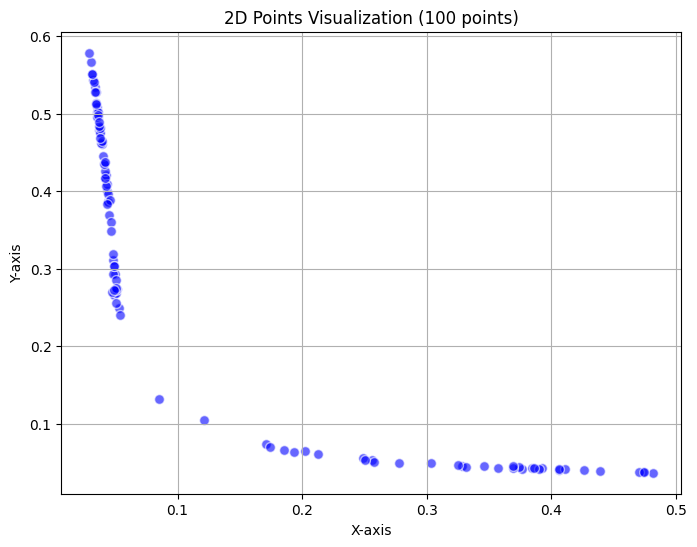

In [10]:
import matplotlib.pyplot as plt
points = ret_points.permute(0,2,1).squeeze(0).T.detach().cpu().numpy()   # shape [100, 2]
plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0], points[:, 1], 
            c='blue', alpha=0.6, 
            edgecolors='w', s=50)

plt.title("2D Points Visualization (100 points)")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.show()